[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 39958, number of negative: 5072647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 5112605, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007816 -> initscore=-4.843789
[LightGBM] [Info] Start training from score -4.843789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

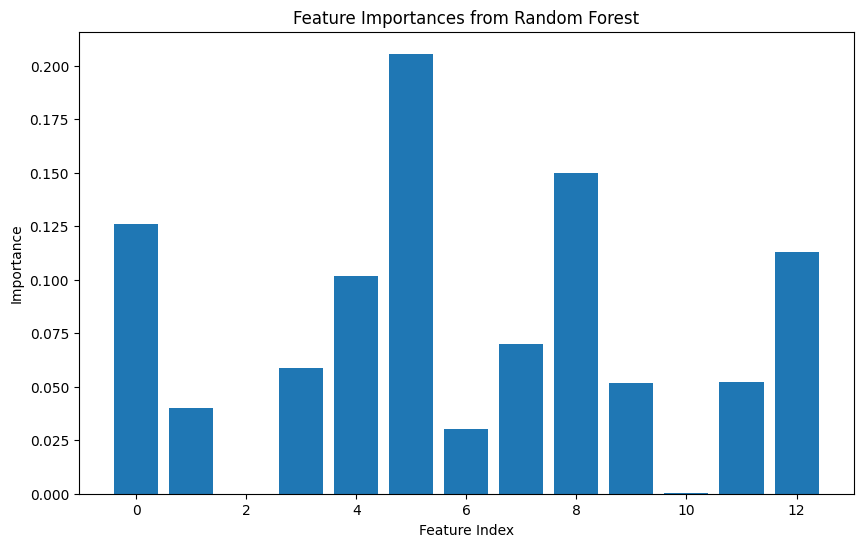

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.combine import SMOTETomek
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier

# Load dataset
df = pd.read_csv("onlinefraud.csv")

# Feature Engineering
df["hour_of_day"] = df["step"] % 24
df["log_amount"] = np.log1p(df["amount"])
df["log_balance_orig"] = np.log1p(df["oldbalanceOrg"])
df["log_balance_dest"] = np.log1p(df["oldbalanceDest"])
df["amount_ratio_orig"] = df["amount"] / (df["oldbalanceOrg"] + 1)
df["amount_ratio_dest"] = df["amount"] / (df["oldbalanceDest"] + 1)

# Remove potential leakage features
df.drop(["error_check_1", "error_check_2"], axis=1, errors="ignore", inplace=True)

# One-Hot Encode 'type'
df = pd.get_dummies(df, columns=["type"], drop_first=True)

# Drop unnecessary columns
df.drop(["nameOrig", "nameDest", "step", "amount", "oldbalanceOrg", "oldbalanceDest"], axis=1, inplace=True)

# Split data
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# Apply SMOTETomek for better synthetic data
smote_tomek = SMOTETomek(sampling_strategy=0.01, random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
joblib.dump(scaler, "scaler.pkl")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=7,
    min_samples_leaf=20,
    min_samples_split=10,
    max_features=0.3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# XGBoost Model
xgb_model = XGBClassifier(
    eval_metric="logloss",
    max_depth=3,
    learning_rate=0.02,
    n_estimators=120,
    scale_pos_weight=15,
    reg_lambda=30,
    reg_alpha=10,
    subsample=0.6,
    colsample_bytree=0.6
)

# LightGBM Model with Improved Parameters
lgbm_model = LGBMClassifier(
    num_leaves=31,  # Increased from 15 to allow more splits
    learning_rate=0.02,
    n_estimators=120,
    colsample_bytree=0.6,
    subsample=0.6,
    reg_lambda=20,
    reg_alpha=10,
    min_child_weight=0.001,  # Reduced to allow smaller splits
    min_data_in_leaf=20  # Reduced slightly if dataset is large
)

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ("rf", rf_model),
        ("xgb", xgb_model),
        ("lgbm", lgbm_model)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
)

# Fit model
stacking_model.fit(X_train, y_train)
joblib.dump(stacking_model, "stacking_model.pkl")

# Model Evaluation
stacking_acc = accuracy_score(y_test, stacking_model.predict(X_test))
stacking_roc_auc = roc_auc_score(y_test, stacking_model.predict_proba(X_test)[:, 1])

print(f"Stacking Model Accuracy: {stacking_acc:.4f}")
print(f"Stacking Model AUC-ROC: {stacking_roc_auc:.4f}")

# Time Series Cross-Validation
cv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(stacking_model, X_scaled, y_resampled, cv=cv, scoring="roc_auc")
print(f"Time Series Cross-Validated AUC-ROC: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Classification Report
print("\nClassification Report for Stacking Model:")
print(classification_report(y_test, stacking_model.predict(X_test)))
print("\nFeature Importances:")
importances = stacking_model.named_estimators_["rf"].feature_importances_
print(importances)
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importances from Random Forest")
plt.show()

